# Weather Prediction - 2-Day Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('seaborn-v0_8-darkgrid')
# sns.set_palette("husl")

## 1. Load and Clean Data

In [2]:
df = pd.read_csv('weatherAUS.csv')

print(f"Number of locations: {df['Location'].nunique()}")
print(df['Location'].unique())

Number of locations: 49
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Location', 'Date']).reset_index(drop=True)

print(f"Total Rows: {len(df):,}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")

Total Rows: 145,460
Date Range: 2007-11-01 00:00:00 to 2017-06-25 00:00:00


In [6]:
df['MinTemp'] = df['MinTemp'].fillna(df['MinTemp'].median())
df['MaxTemp'] = df['MaxTemp'].fillna(df['MaxTemp'].median())
df['TempMean'] = (df['MinTemp'] + df['MaxTemp']) / 2
df['TempRange'] = df['MaxTemp'] - df['MinTemp']
df['TempRange'] = df['TempRange'].clip(lower=0.1)  

# Fill Evaporation using Hargreaves-Samani formula
Ra = 20  # Solar radiation constant for Australia
df['Evaporation_Est'] = 0.0023 * (df['TempMean'] + 17.8) * (df['TempRange'] ** 0.5) * Ra
df['Evaporation_Est'] = df['Evaporation_Est'].fillna(df['Evaporation_Est'].median())
df['Evaporation'] = df['Evaporation'].fillna(df['Evaporation_Est'])

# Fill remaining numeric columns with median
for col in df.select_dtypes(include=[np.number]).columns:
    if col not in ['MinTemp', 'MaxTemp', 'Evaporation', 'TempMean', 'TempRange', 'Evaporation_Est']:
        df[col] = df[col].fillna(df[col].median())

# Fill categorical with mode
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['Date', 'Location']:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'No'
        df[col] = df[col].fillna(mode_val)

# Create binary rain columns
df['RainTomorrow_Binary'] = (df['RainTomorrow'] == 'Yes').astype(int)
df['RainToday_Binary'] = (df['RainToday'] == 'Yes').astype(int)

print(f"Missing values: {df.isnull().sum().sum()}")

Missing values: 0


In [7]:
# Rain tomorrow given rain today
rain_given_rain = df[df['RainToday'] == 'Yes']['RainTomorrow_Binary'].mean() * 100
print(f"Rain Tomorrow if Rained Today: {rain_given_rain:.1f}%")

# Rain tomorrow given no rain today
rain_given_no_rain = df[df['RainToday'] == 'No']['RainTomorrow_Binary'].mean() * 100
print(f"Rain Tomorrow if No Rain Today: {rain_given_no_rain:.1f}%")

Rain Tomorrow if Rained Today: 45.8%
Rain Tomorrow if No Rain Today: 15.2%


In [8]:
# Save cleaned data for dashboard
df.to_csv('weatherAUS_cleaned.csv', index=False)

### Feature Selection

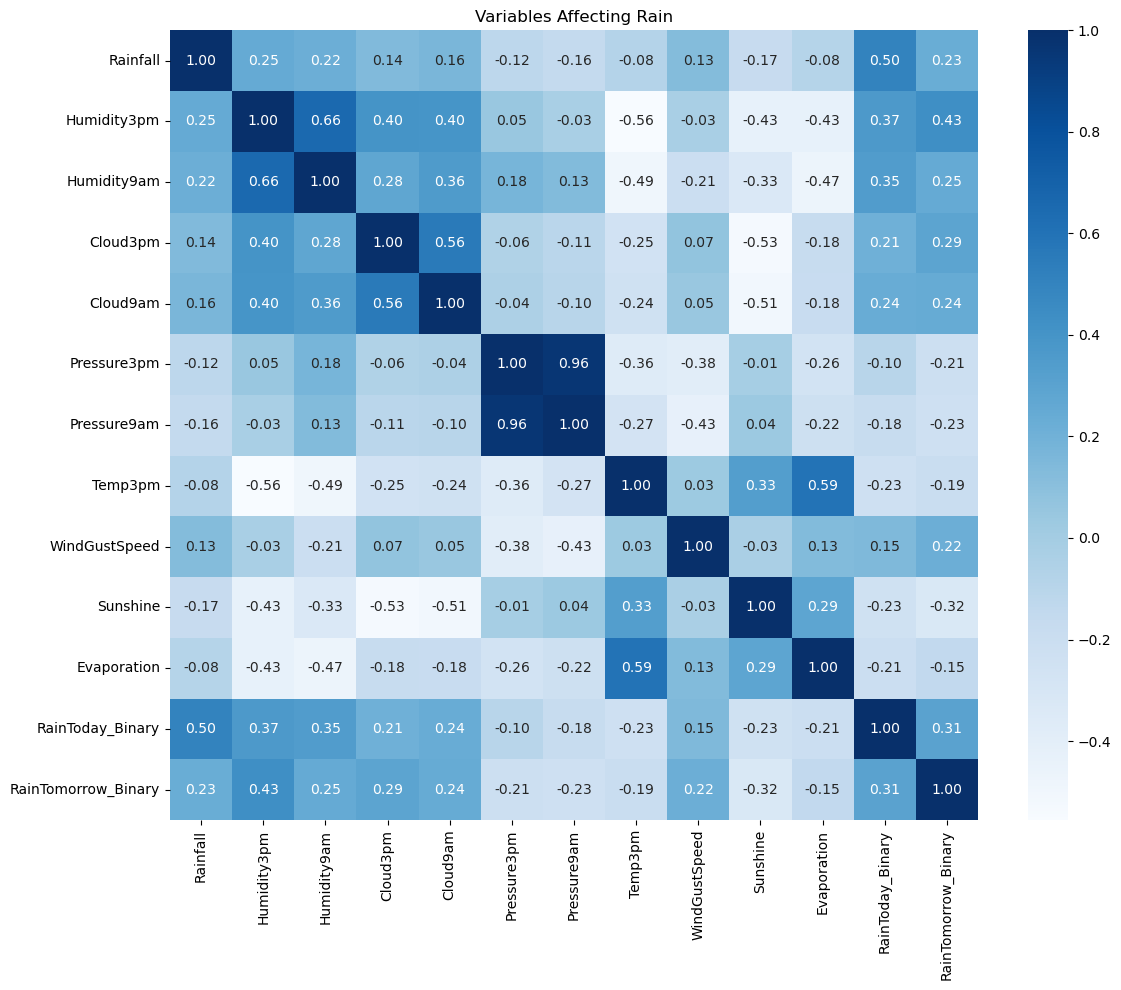

Top Features Correlated with RainTomorrow:
RainTomorrow_Binary    1.000000
Humidity3pm            0.433167
RainToday_Binary       0.305744
Cloud3pm               0.290610
Humidity9am            0.251415
Cloud9am               0.244242
Rainfall               0.233877
WindGustSpeed          0.220144
Evaporation           -0.145699
Temp3pm               -0.187721
Pressure3pm           -0.211952
Pressure9am           -0.230950
Sunshine              -0.319412
Name: RainTomorrow_Binary, dtype: float64


In [9]:
# Select important variables for analysis
important_vars = ['Rainfall', 'Humidity3pm', 'Humidity9am', 'Cloud3pm', 'Cloud9am',
                 'Pressure3pm', 'Pressure9am', 'Temp3pm', 'WindGustSpeed',
                 'Sunshine', 'Evaporation', 'RainToday_Binary', 'RainTomorrow_Binary']

plt.figure(figsize=(12, 10))
sns.heatmap(df[important_vars].corr(), annot=True, fmt='.2f', cmap='Blues')
plt.title('Variables Affecting Rain')
plt.tight_layout()
plt.show()

correlations_with_target = df[important_vars].corr()['RainTomorrow_Binary'].sort_values(ascending=False)
print("Top Features Correlated with RainTomorrow:")
print(correlations_with_target)

## 3. Build Simple Prediction Model

In [10]:
def calculate_rain_probability(data, sunshine, humidity, cloud, rain_today):
    
    # Find similar days
    conditions = (
        (data['Sunshine'].between(sunshine - 2, sunshine + 2)) &
        (data['Humidity3pm'].between(humidity - 10, humidity + 10)) &
        (data['Cloud3pm'].between(cloud - 1, cloud + 1)) &
        (data['RainToday_Binary'] == (1 if rain_today == 'Yes' else 0))
    )
    
    similar_days = data[conditions]
    
    # If not enough data, widen the range
    if len(similar_days) < 5:
        conditions = (
            (data['Sunshine'].between(sunshine - 4, sunshine + 4)) &
            (data['Humidity3pm'].between(humidity - 20, humidity + 20)) &
            (data['Cloud3pm'].between(cloud - 2, cloud + 2))
        )
        similar_days = data[conditions]
    
    # If still no data, use overall average
    if len(similar_days) == 0:
        return data['RainTomorrow_Binary'].mean() * 100, 0
    
    probability = similar_days['RainTomorrow_Binary'].mean() * 100
    confidence = min(len(similar_days) / 100, 1.0) * 100
    
    return probability, confidence

def predict_next_2_days(data, sunshine, humidity, cloud, rain_today):
   
    # Day 1 prediction
    prob_day1, conf_day1 = calculate_rain_probability(data, sunshine, humidity, cloud, rain_today)
    
    # Day 2 prediction (assuming day 1 outcome based on probability)
    will_rain_day1 = 'Yes' if prob_day1 > 50 else 'No'
    prob_day2, conf_day2 = calculate_rain_probability(data, sunshine, humidity, cloud, will_rain_day1)
    
    return {
        'day1': {'probability': prob_day1, 'confidence': conf_day1},
        'day2': {'probability': prob_day2, 'confidence': conf_day2}
    }


## 4. Test the Model

In [11]:
test_row = df.iloc[-150] 

print(f"Date: {test_row['Date']}")
print(f"Location: {test_row['Location']}")
print(f"Sunshine: {test_row['Sunshine']:.1f} hours")
print(f"Humidity (3pm): {test_row['Humidity3pm']:.0f}%")
print(f"Cloud (3pm): {test_row['Cloud3pm']:.0f}/8")
print(f"Rained Today: {test_row['RainToday']}")

result = predict_next_2_days(
    df,
    test_row['Sunshine'],
    test_row['Humidity3pm'],
    test_row['Cloud3pm'],
    test_row['RainToday']
)
print("\nPREDICTIONS:")
print(f"Day 1: {result['day1']['probability']:.1f}% ")
print(f"Day 2: {result['day2']['probability']:.1f}% ")

Date: 2017-01-27 00:00:00
Location: Woomera
Sunshine: 8.4 hours
Humidity (3pm): 18%
Cloud (3pm): 5/8
Rained Today: No

PREDICTIONS:
Day 1: 5.4% 
Day 2: 5.4% 


## 5. Visualize Key Factors

C:\Users\moham\AppData\Local\Temp\ipykernel_14844\258300873.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sunshine_prob = df.groupby(pd.cut(df['Sunshine'], bins=10))['RainTomorrow_Binary'].mean() * 100
C:\Users\moham\AppData\Local\Temp\ipykernel_14844\258300873.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  humidity_prob = df.groupby(pd.cut(df['Humidity3pm'], bins=10))['RainTomorrow_Binary'].mean() * 100


Chart saved: rain_factors.png


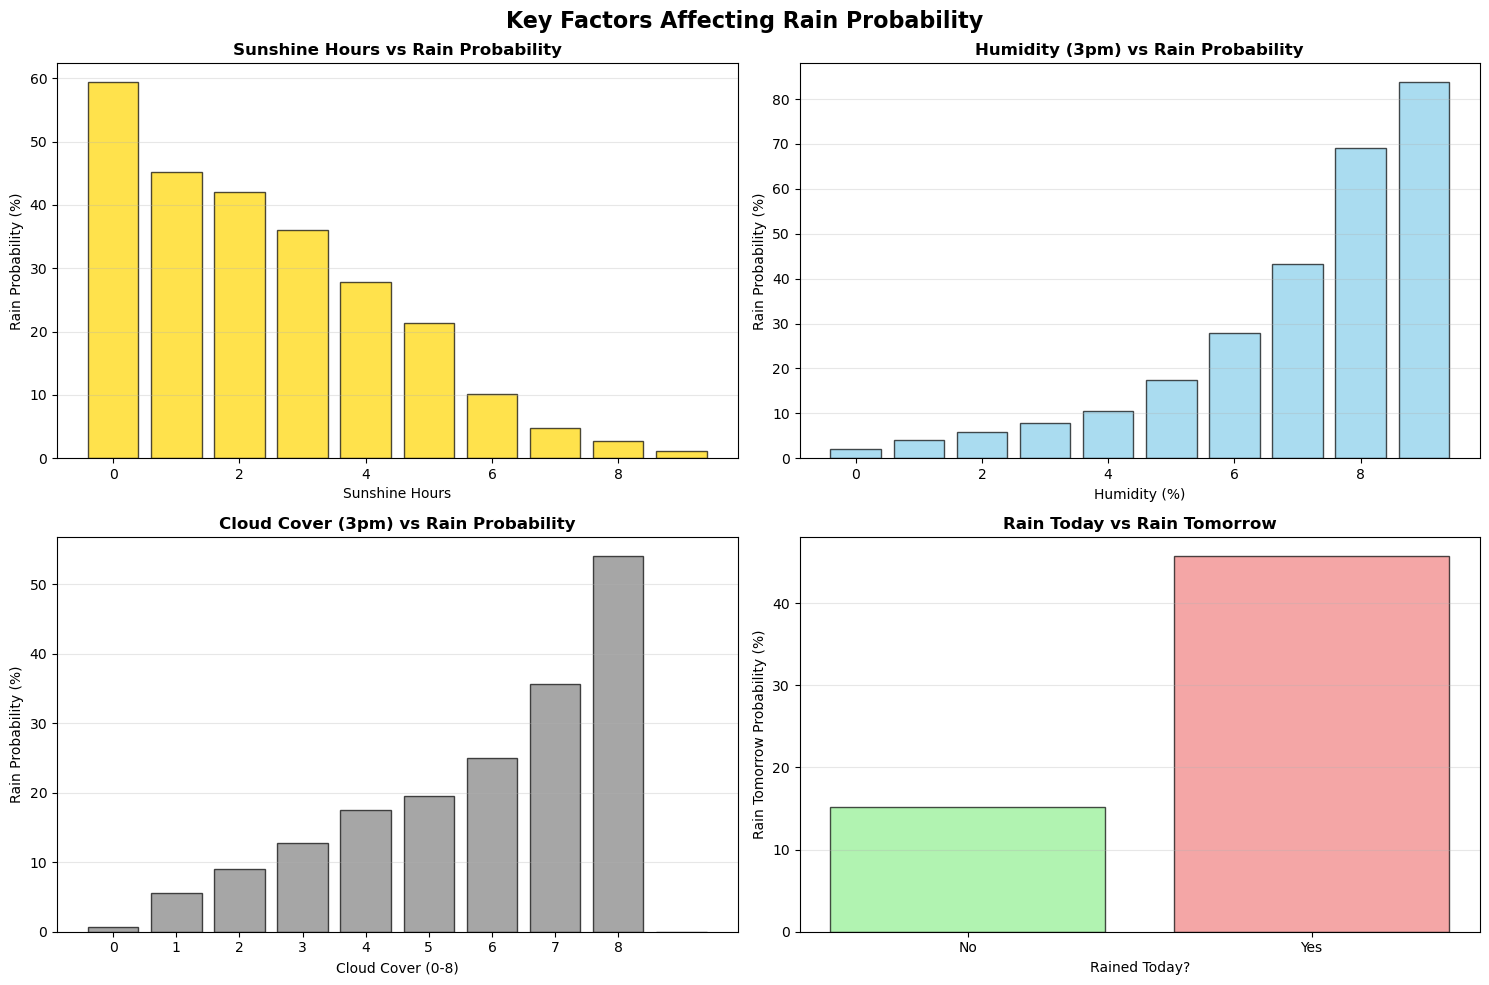

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Key Factors Affecting Rain Probability', fontsize=16, fontweight='bold')

# 1. Sunshine
ax = axes[0, 0]
sunshine_prob = df.groupby(pd.cut(df['Sunshine'], bins=10))['RainTomorrow_Binary'].mean() * 100
x_pos = range(len(sunshine_prob))
ax.bar(x_pos, sunshine_prob.values, color='gold', alpha=0.7, edgecolor='black')
ax.set_title('Sunshine Hours vs Rain Probability', fontweight='bold')
ax.set_xlabel('Sunshine Hours')
ax.set_ylabel('Rain Probability (%)')
ax.grid(axis='y', alpha=0.3)

# 2. Humidity
ax = axes[0, 1]
humidity_prob = df.groupby(pd.cut(df['Humidity3pm'], bins=10))['RainTomorrow_Binary'].mean() * 100
x_pos = range(len(humidity_prob))
ax.bar(x_pos, humidity_prob.values, color='skyblue', alpha=0.7, edgecolor='black')
ax.set_title('Humidity (3pm) vs Rain Probability', fontweight='bold')
ax.set_xlabel('Humidity (%)')
ax.set_ylabel('Rain Probability (%)')
ax.grid(axis='y', alpha=0.3)

# 3. Cloud Cover
ax = axes[1, 0]
cloud_prob = df.groupby('Cloud3pm')['RainTomorrow_Binary'].mean() * 100
ax.bar(cloud_prob.index, cloud_prob.values, color='gray', alpha=0.7, edgecolor='black')
ax.set_title('Cloud Cover (3pm) vs Rain Probability', fontweight='bold')
ax.set_xlabel('Cloud Cover (0-8)')
ax.set_ylabel('Rain Probability (%)')
ax.set_xticks(range(0, 9))
ax.grid(axis='y', alpha=0.3)

# 4. Rain Today
ax = axes[1, 1]
rain_today_prob = df.groupby('RainToday')['RainTomorrow_Binary'].mean() * 100
colors = ['lightgreen', 'lightcoral']
ax.bar(rain_today_prob.index, rain_today_prob.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Rain Today vs Rain Tomorrow', fontweight='bold')
ax.set_xlabel('Rained Today?')
ax.set_ylabel('Rain Tomorrow Probability (%)')
ax.grid(axis='y', alpha=0.3)

for txt in ax.get_xticklabels():
    txt.set_fontsize(10)

plt.tight_layout()
plt.savefig('rain_factors.png', dpi=300, bbox_inches='tight')
print("Chart saved: rain_factors.png")
plt.show()

## 6. Model Accuracy Test

In [13]:
# Test on random sample
test_sample = df.sample(1000, random_state=42)
correct = 0

for idx, row in test_sample.iterrows():
    pred = predict_next_2_days(
        df,
        row['Sunshine'],
        row['Humidity3pm'],
        row['Cloud3pm'],
        row['RainToday']
    )
    
    predicted_rain = pred['day1']['probability'] > 50
    actual_rain = row['RainTomorrow'] == 'Yes'
    
    if predicted_rain == actual_rain:
        correct += 1

accuracy = (correct / len(test_sample)) * 100
print(f"Model Accuracy: {accuracy:.1f}%")

Model Accuracy: 83.4%


## 7. Interactive Prediction Function

In [14]:
def predict_for_location(location, sunshine, humidity, cloud, rain_today):

    df_loc = df[df['Location'] == location]
    
    result = predict_next_2_days(df_loc, sunshine, humidity, cloud, rain_today)
    
    print(f"\nPredictions:")
    print(f"Tomorrow (Day 1): {result['day1']['probability']:.1f}%")
    print(f"Day After Tomorrow (Day 2): {result['day2']['probability']:.1f}%")
    
    return result

# Example usage
result = predict_for_location(
    location='Sydney',
    sunshine=6.5,
    humidity=70,
    cloud=6,
    rain_today='No'
)


Predictions:
Tomorrow (Day 1): 31.5%
Day After Tomorrow (Day 2): 31.5%
